# Assignment 2: sentiment analysis of SUTD Reddit
**Assignment due 21 March 11:59pm**

Welcome to the second assignment for 50.055 Machine Learning Operations. These assignments give you a chance to practice the methods and tools you have learned. 

**This assignment is an individual assignment.**

- Read the instructions in this notebook carefully
- Add your solution code and answers in the appropriate places. The questions are marked as **QUESTION:**, the places where you need to add your code and text answers are marked as **ADD YOUR SOLUTION HERE**
- The completed notebook, including your added code and generated output and a labeled dataset which you create in the assignment will be your submission for the assignment.
- The notebook should execute without errors from start to finish when you select "Restart Kernel and Run All Cells..". Please test this before submission.
- Use the SUTD Education Cluster to solve and test the assignment.

**Rubric for assessment** 

Your submission will be graded using the following criteria. 
1. Code executes: your code should execute without errors. The SUTD Education cluster should be used to ensure the same execution environment.
2. Correctness: the code should produce the correct result or the text answer should state the factual correct answer.
3. Style: your code should be written in a way that is clean and efficient. Your text answers should be relevant, concise and easy to understand.
4. Partial marks will be awarded for partially correct solutions.
5. There is a maximum of 150 points for this assignment.

**ChatGPT policy** 

If you use AI tools, such as ChatGPT, to solve the assignment questions, you need to be transparent about its use and mark AI-generated content as such. In particular, you should include the following in addition to your final answer:
- A copy or screenshot of the prompt you used
- The name of the AI model
- The AI generated output
- An explanation why the answer is correct or what you had to change to arrive at the correct answer

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.


In [1]:
# # Installing all required packages
# # Note: Do not add to this list.
# # ----------------
# ! pip install transformers[torch]==4.37.2
# ! pip install datasets==2.17.1
# ! pip install seaborn==0.13.2
# ! pip install pyarrow==15.0.0
# ! pip install scikit-learn==1.4.0
# ! pip install emoji==0.6.0
# ! pip install accelerate==0.27.2
# # ----------------

In [2]:
# # Install PyTorch with CUDA support
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [3]:
# Importing all required packages
# ----------------
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
# ----------------

c:\Users\adity\Desktop\Machine Learning Operations\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%matplotlib inline


# Sentiment analysis

Sentiment analysis is a natural language processing technique that identifies the polarity of a given text. There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive, negative and neutral. We have already encountererd sentiment analysis in the hands-on sessions.

In this assignment, you will conduct sentiment analysis on posts and comments from the SUTD subreddit. You will run experiments with pre-trained sentiment models, evaluate their performance and simulate improving the model by re-training it with newly annotated data. 


In [5]:
# Load SUTD subreddit data set as dataframe
# posts and comments have been downloaded from https://www.reddit.com/r/sutd/

df_submissions = pd.read_parquet('reddit_submissions.parquet.gzip').set_index("Id")
df_comments = pd.read_parquet('reddit_comments.parquet.gzip').set_index("CommentId")

In [6]:
#Let's have a look at the data. The data schema is as follows.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time

# Comments
# CommentId - unique id for comment
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time
# Id - unique id for submission on which the comment was posted

# See the Reddit API documentation for details https://www.reddit.com/dev/api/
df_submissions

,Title,Upvotes,Created
Id,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35
zzxqop,Happy New Year!,339,2022-12-31 16:26:57
rbe5cz,Happy finals!,319,2021-12-08 00:45:22
zlci46,You know who you are,266,2022-12-14 00:46:23
...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34


In [7]:
df_comments

,Comment,CommentCreated,Id
CommentId,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop
...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4


You can read the SUTD reddit submissions in your web browser by navigating to 
https://www.reddit.com/r/sutd/comments/{Id}


### QUESTION: 
How easy is it to make sense of the submissions and comments? Is it easier to understand the posts when you read them in the browser? 
Explain why or why not (max 100 words)

**--- ADD YOUR SOLUTION HERE (5 points)---**

Reading the submissions and comments in the browser is much easier especially for the Reddit format where there are submissions and comments. The browser provides a better visual hierarchy and makes it easier to read the posts. Most submissions are usually with images and videos which are shown in the browser and make the context of the post more clear.

------------------------------


In [8]:
# QUESTION: Join the data frames into a joined data_frame 'df_reddit' which  contains both submissions and comments. 
# Each row should contain a submission paired with one associated comment. Comments that do not have a matching submission shall be dropped. The joined data frame should have the following schema.

# Submissions
# Id - unique id for submission
# Title - text of the submission title
# Upvotes - upvotes on this submission
# Created - date time of submission creation date and time
# CommentId - unique id for comment, comment is posted for this submission
# Comment - text content of the comment
# CommentCreated - date time of comment creation date and time


#--- ADD YOUR SOLUTION HERE (5 points)---
# since you mentioned that the comments that dont have a matching submission are dropped, we can use inner join (merge)

df_reddit = df_comments.reset_index().merge(df_submissions.reset_index(), on='Id', how='inner')
# rearranging the columns to the asked order
df_reddit = df_reddit[['Id', 'Title', 'Upvotes', 'Created', 'CommentId', 'Comment', 'CommentCreated']]
df_reddit
#------------------------------

,Id,Title,Upvotes,Created,CommentId,Comment,CommentCreated
0,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29
1,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59
2,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01
3,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53
4,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21
...,...,...,...,...,...,...,...
2966,axezas,How is the SUTD skype interview like?,3,2019-03-05 01:02:11,ei4kuvo,How long did it take?,2019-03-09 07:22:03
2967,atijac,Open house starts tomorrow. Ask an ESD Senior ...,3,2019-02-22 14:59:05,eh1uhxo,Are banks evil?,2019-02-22 19:32:56
2968,atijac,Open house starts tomorrow. Ask an ESD Senior ...,3,2019-02-22 14:59:05,eh2i3xd,Should I come to the open house?,2019-02-23 00:14:53
2969,atijac,Open house starts tomorrow. Ask an ESD Senior ...,3,2019-02-22 14:59:05,eh2tvkj,I generally don't like questions re: good and ...,2019-02-23 03:03:36


In [9]:
# Print the first 10 rows of the joined data frame
df_reddit.head(10)

# Hint: submission will be duplicated as many times as there are comments

,Id,Title,Upvotes,Created,CommentId,Comment,CommentCreated
0,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29
1,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59
2,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01
3,xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53
4,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21
5,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j54ub3e,"HEY, FUCK YOU",2023-01-20 12:15:41
6,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2hjzse,"Meanwhile me who has work on christmas eve, ch...",2023-01-01 09:44:48
7,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2i7d80,hahahaaha same,2023-01-01 14:48:55
8,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j2m5mdr,f school man,2023-01-02 09:54:47
9,zzxqop,Happy New Year!,339,2022-12-31 16:26:57,j4fvc93,Same,2023-01-15 12:41:33


In [10]:
# Now let's run a pre-trained sentiment analysis model on the submissions and comments
# A convenient way to execute pre-trained models for standard tasks are Huggingface pipelines
# Here we run a standard sentiment analysis pipeline on the first ten submission titles 
sentiment_pipeline = pipeline("sentiment-analysis", device=0)
print(sentiment_pipeline(list(df_submissions['Title'][:10])))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\adity\Desktop\Machine Learning Operations\env\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'label': 'POSITIVE', 'score': 0.9927398562431335}, {'label': 'NEGATIVE', 'score': 0.7195636630058289}, {'label': 'POSITIVE', 'score': 0.999868631362915}, {'label': 'POSITIVE', 'score': 0.9998632669448853}, {'label': 'POSITIVE', 'score': 0.9992561936378479}, {'label': 'POSITIVE', 'score': 0.5723459720611572}, {'label': 'NEGATIVE', 'score': 0.9995667338371277}, {'label': 'POSITIVE', 'score': 0.9972499012947083}, {'label': 'NEGATIVE', 'score': 0.9956018924713135}, {'label': 'NEGATIVE', 'score': 0.9826338887214661}]


In [11]:
# QUESTION: Complete the function 'analyse_sentiment' which takes a data frame, a Huggingface sentiment pipeline object 
# and a target column name and adds two columns 'Label' and 'Score' to the data frame in place.
# pass the provided tokenizer arguments to the pipeline
# The new columns should contain the sentiment labels and scores, respectively.


#--- ADD YOUR SOLUTION HERE (10 points)---
def analyse_sentiment(df, sentiment_pipeline, column):
    tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':128,}
    # get the pipeine sentiment analysis results
    pipeline_result = sentiment_pipeline(list(df[column]), **tokenizer_kwargs) # the ** is to unpack the dictionary
    #unpack the results
    labels = [result['label'] for result in pipeline_result]
    scores = [result['score'] for result in pipeline_result]
    #finally add the new columns
    df['Label'] = labels
    df['Score'] = scores
    return df
#------------------------------

In [12]:
# add sentiment labels and scores to the submissions and comments dataframes
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,NEGATIVE,0.881345
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,POSITIVE,0.987902
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,NEGATIVE,0.999672
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEGATIVE,0.992340
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEGATIVE,0.696360
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POSITIVE,0.999398
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,POSITIVE,0.619022
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,POSITIVE,0.651069


In [13]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POSITIVE,0.992740
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEGATIVE,0.719564
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POSITIVE,0.999869
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POSITIVE,0.999863
zlci46,You know who you are,266,2022-12-14 00:46:23,POSITIVE,0.999256
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEGATIVE,0.998578
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,POSITIVE,0.845063
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POSITIVE,0.967637


In [14]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,NEGATIVE,0.881345
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,POSITIVE,0.987902
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,NEGATIVE,0.999672
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEGATIVE,0.992340
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEGATIVE,0.696360
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POSITIVE,0.999398
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,POSITIVE,0.619022
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,POSITIVE,0.651069


### QUESTION: 
From a first inspection of the results, what problems can you see with our current sentiment analysis?
What model is used for the sentiment analysis and how was is trained?

**--- ADD YOUR SOLUTION HERE (5 points) ---**

The model appears to misclassify like ironic statements. The first example, "Oh boy, 8am lectures. My favorite" is classified as POSITIVE when it's obviously sarcastic.
likewise, submissions like "Happy finals!" might be positive on the surface but in context it could actually be sarcastic.

Not just that, examples like "Me everyday on a school day," "jan 3rd is when my secondary school starts" and "upcoming SUTD interviews" have no clear sentiment but are forced positive or negative sentiments by the model since it's trained to classify them as such.

Since no model was applied it defaulted to distilbert-base-uncased-finetuned-sst-2-english<br>
Since the pipeline was not trained it defaulted to a pretrained and finetuned model, and on research on this model has been pretrained on  general English text i think (using MLM) and then fine-tuned on the SST-2 (Stanford Sentiment Treebank v2) dataset for classification. 

------------------------------


In [15]:
# QUESTION: Update the sentiment pipeline to use the model "finiteautomata/bertweet-base-sentiment-analysis" from Huggingface
# The model should output three classes: 'POS', 'NEG', 'NEU'
# Store the model name in separate variable "model_name"

#--- ADD YOUR SOLUTION HERE (5 points) ---
model_name= "finiteautomata/bertweet-base-sentiment-analysis"
sentiment_pipeline = pipeline("sentiment-analysis", device=0, model=model_name)
print(sentiment_pipeline(list(df_submissions['Title'][:10])))
print(df_submissions.columns)
#------------------------------


c:\Users\adity\Desktop\Machine Learning Operations\env\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'label': 'POS', 'score': 0.9874617457389832}, {'label': 'NEU', 'score': 0.846713662147522}, {'label': 'POS', 'score': 0.9924977421760559}, {'label': 'POS', 'score': 0.992440938949585}, {'label': 'NEU', 'score': 0.6117528080940247}, {'label': 'POS', 'score': 0.6473566889762878}, {'label': 'NEG', 'score': 0.8963016271591187}, {'label': 'POS', 'score': 0.9389116764068604}, {'label': 'NEU', 'score': 0.97343510389328}, {'label': 'NEU', 'score': 0.9616515636444092}]
Index(['Title', 'Upvotes', 'Created', 'Label', 'Score'], dtype='object')


### QUESTION: 

Explain why this model is better suited for the task (max 100 words).

**--- ADD YOUR SOLUTION HERE (5 points) ---**

It solves the problem mentioned above. This model includes a neutral (NEU) category. It's even trained on the twitter data, so it's mrore sutited to handle the slangs and informal language. The model can better understand academic context and sarcasm since it was trained on more diverse content than just movie reviews.

------------------------------


In [16]:
# re-run the sentiment analysis of submissions and comments
analyse_sentiment(df_submissions, sentiment_pipeline, 'Title')
analyse_sentiment(df_comments, sentiment_pipeline, 'Comment')

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,POS,0.764861
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,NEU,0.932430
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,POS,0.808931
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEU,0.962069
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEU,0.972655
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POS,0.968053
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,NEG,0.874082
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,NEG,0.901180


In [17]:
# display dataframe 
df_submissions

,Title,Upvotes,Created,Label,Score
Id,,,,,
xtdia0,"Oh boy, 8am lectures. My favorite",627,2022-10-02 02:49:01,POS,0.987462
scyaig,IF I get my engineering degree,413,2022-01-26 05:24:35,NEU,0.846714
zzxqop,Happy New Year!,339,2022-12-31 16:26:57,POS,0.992498
rbe5cz,Happy finals!,319,2021-12-08 00:45:22,POS,0.992441
zlci46,You know who you are,266,2022-12-14 00:46:23,NEU,0.611753
...,...,...,...,...,...
b7nv4i,SUTD started sending rejection letter already?,3,2019-03-31 13:41:25,NEG,0.825060
b579t4,upcoming SUTD interviews,3,2019-03-25 06:47:32,NEU,0.963418
b41vpw,Another new (prospective) undergraduate!,3,2019-03-22 07:04:34,POS,0.675288


In [18]:
# display dataframe 
df_comments

,Comment,CommentCreated,Id,Label,Score
CommentId,,,,,
iqps23l,HAHA Issa mood boiii,2022-10-02 05:25:29,xtdia0,POS,0.764861
iqrmg9d,Me everyday on a school day,2022-10-02 16:26:59,xtdia0,NEU,0.932430
iqso6tt,Nothing a Vid test can't fix,2022-10-02 20:19:01,xtdia0,POS,0.808931
iqpmt6t,I thought the earliest lecture we can get is 8...,2022-10-02 04:26:53,xtdia0,NEU,0.962069
j2gyvln,jan 3rd is when my secondary school starts,2023-01-01 05:13:21,zzxqop,NEU,0.972655
...,...,...,...,...,...
jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,13jqat4,POS,0.968053
johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,13jqat4,NEG,0.874082
jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,13jqat4,NEG,0.901180


In [19]:
# QUESTION: What is the time frame covered by the data set, i.e. what is the earliest time of a submission or comment and what is the most recent time?
# Find the earliest and latest timestamp and print them
#--- ADD YOUR SOLUTION HERE (8 points)---
# get the earliest and latest timestamps for submissions and comments

earliest_submission = df_submissions['Created'].min()
latest_submission = df_submissions['Created'].max()
earliest_comment = df_comments['CommentCreated'].min()
latest_comment = df_comments['CommentCreated'].max()

# get the earliest and latest timestamps for all the data together
earliest_time = min(earliest_submission, earliest_comment)
latest_time = max(latest_submission, latest_comment)

print(f"Earliest time: {earliest_time}")
print(f"Latest time: {latest_time}")
#------------------------------

Earliest time: 2017-11-12 17:06:27
Latest time: 2024-01-24 03:39:32


Year
2017      9
2018      6
2019     56
2020    140
2021    151
2022    109
2023    118
2024      5
dtype: int64


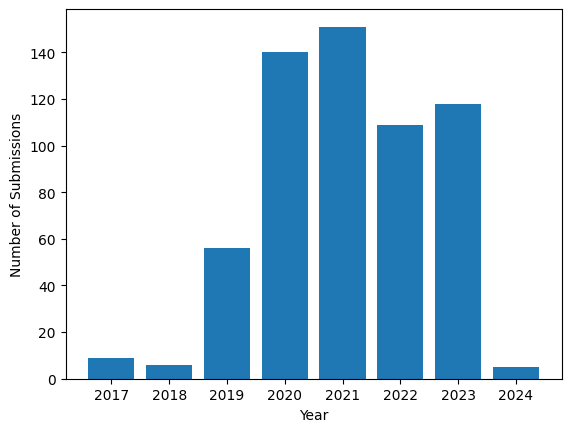

In [20]:
# QUESTION: How did the volume of posts on the SUTD subreddit change over the years?
# Create a bar chart diagram that plots the number of submissions per year on the y-axis and the year on the x-axis.

#--- ADD YOUR SOLUTION HERE (8 points) ---
# i need to group by year and then count the number of posts (only submissions)
# get the year from the created column (using dt from pandas)
df_submissions['Year'] = df_submissions['Created'].dt.year
submissions_per_year = df_submissions.groupby('Year').size()
print(submissions_per_year)

plt.figure()
plt.bar(submissions_per_year.index, submissions_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Submissions')
plt.show()

#------------------------------

Label
NEU    518
NEG     41
POS     35
Name: count, dtype: int64


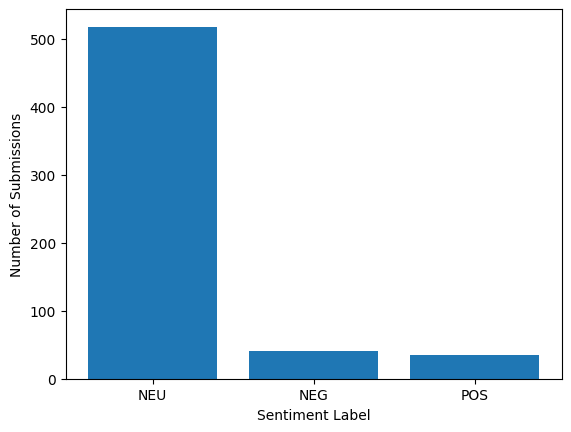

In [21]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment?
# Create a bar chart diagram that plots the number of submissions on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
# the idea will be to create a bar chart with three bars, one for each sentiment label
# so all I need is to get the counts for each sentiment label using value_counts()

submissions_per_sentiment = df_submissions['Label'].value_counts()
print(submissions_per_sentiment)

plt.figure()
plt.bar(submissions_per_sentiment.index, submissions_per_sentiment.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Submissions')
plt.show()
#------------------------------

Label
NEU    2291
POS    1203
NEG     410
Name: count, dtype: int64


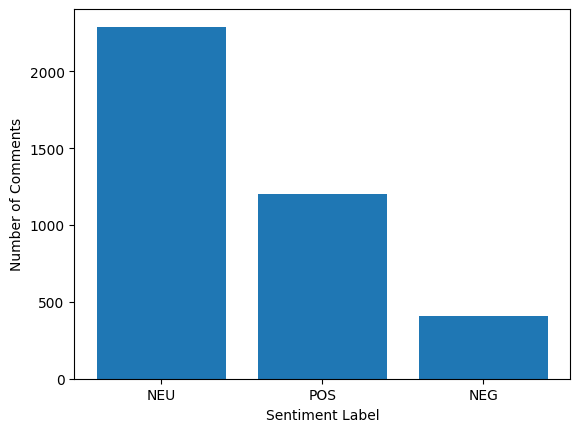

In [22]:
# QUESTION: What is the distribution of positive, neutral and negative sentiment for comments?
# Create a bar chart diagram that plots the number of comments on the y-axis and the sentiment label on the x-axis.

#--- ADD YOUR SOLUTION HERE (5 points)---
comments_per_sentiment = df_comments['Label'].value_counts()
print(comments_per_sentiment)

plt.figure()
plt.bar(comments_per_sentiment.index, comments_per_sentiment.values)
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Comments')
plt.show()
#------------------------------

In [ ]:
# QUESTION: combine submission titles and comments for the time period from 2021 until today into one data frame.
# The resulting data frame 'df_text' should have the following schema

# Id - unique id of the comment or the submissions, this column is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML

#--- ADD YOUR SOLUTION HERE (10 points)---
# print(df_submissions.head())
filter_submissions = df_submissions[df_submissions["Created"] >= "2021-01-01"]
filter_comments = df_comments[df_comments["CommentCreated"] >= "2021-01-01"]
print(filter_submissions.columns)
print(filter_comments.columns)

subs_renamed = filter_submissions[['Title', 'Created', 'Label']].rename(columns={'Title': 'Text'})
subs_renamed['Id'] = filter_submissions.index # this was the major fix (since the index was not a separate Column)
comms_renamed = filter_comments[['Comment', 'CommentCreated', 'Label']].rename(columns={'Comment': 'Text', 'CommentCreated': 'Created'})
comms_renamed['Id'] = filter_comments.index

df_text = pd.concat([subs_renamed[['Id', 'Text', 'Created', 'Label']], comms_renamed[['Id', 'Text', 'Created', 'Label']]])

#------------------------------

                                    Title  Upvotes             Created Label  \
Id                                                                             
xtdia0  Oh boy, 8am lectures. My favorite      627 2022-10-02 02:49:01   POS   
scyaig     IF I get my engineering degree      413 2022-01-26 05:24:35   NEU   
zzxqop                    Happy New Year!      339 2022-12-31 16:26:57   POS   
rbe5cz                      Happy finals!      319 2021-12-08 00:45:22   POS   
zlci46               You know who you are      266 2022-12-14 00:46:23   NEU   

           Score  Year  
Id                      
xtdia0  0.987462  2022  
scyaig  0.846714  2022  
zzxqop  0.992498  2022  
rbe5cz  0.992441  2021  
zlci46  0.611753  2022  
Index(['Title', 'Upvotes', 'Created', 'Label', 'Score', 'Year'], dtype='object')
Index(['Comment', 'CommentCreated', 'Id', 'Label', 'Score'], dtype='object')


In [71]:
# inspect the resulting data frame
df_text

,Id,Text,Created,Label
xtdia0,xtdia0,"Oh boy, 8am lectures. My favorite",2022-10-02 02:49:01,POS
scyaig,scyaig,IF I get my engineering degree,2022-01-26 05:24:35,NEU
zzxqop,zzxqop,Happy New Year!,2022-12-31 16:26:57,POS
rbe5cz,rbe5cz,Happy finals!,2021-12-08 00:45:22,POS
zlci46,zlci46,You know who you are,2022-12-14 00:46:23,NEU
...,...,...,...,...
jkrjznb,jkrjznb,hey! got my acceptance today,2023-05-19 12:45:12,POS
johzqeu,johzqeu,"hi y’allz, mine updated to unsuccessful, wishi...",2023-06-17 18:50:10,NEG
jo1hrsu,jo1hrsu,I’m an international student from china and I ...,2023-06-13 22:37:17,NEG
jklk6o3,jklk6o3,Congratulation! Did you get any scholarship?,2023-05-18 05:02:25,POS


In [72]:
# QUESTION: sort the data frame by date time descending and save it in the same variable

#--- ADD YOUR SOLUTION HERE (3 points)---
df_text = df_text.sort_values('Created', ascending=False)
#------------------------------

In [73]:
# inspect the resulting data frame
df_text

,Id,Text,Created,Label
kjaudx2,kjaudx2,Unfortunately no and I don’t foresee it to cha...,2024-01-24 03:39:32,NEG
kjau765,kjau765,Hi! I would like to ask if it is possible for ...,2024-01-24 03:38:13,NEU
kj74anz,kj74anz,"Thks! Hope you have a great FEAST II, all the ...",2024-01-23 14:25:22,POS
kj6z72l,kj6z72l,"I see, wishing you all the best for the result...",2024-01-23 13:50:05,POS
kj6x184,kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",2024-01-23 13:34:29,POS
...,...,...,...,...
ghwf0at,ghwf0at,Yes. I am indoneisan myself. In fact we have a...,2021-01-03 04:32:08,NEU
kpde9d,kpde9d,Subjects in Year 1,2021-01-03 04:13:53,NEU
kp0zuf,kp0zuf,HASS mod recommendation,2021-01-02 17:02:09,NEU
kovm76,kovm76,I am currently still in highschool (indo) and ...,2021-01-02 10:52:03,NEU


In [74]:
# save data frame to csv
df_text.to_csv("reddit.csv")


Download the csv file and open it in a spreadsheet application or text editor. 

Inspec the first 10-20 entries in the list to get a feeling for the data domain.

### QUESTION: 
Write a short labeling guide for annotating the SUTD reddit data with sentiment labels. 
You can write the labeling guide in a bullet point format and should have 5-10 points.

**--- ADD YOUR SOLUTION HERE (10 points)---** <br>
After reviewing the first 15 entires in reddit.csv, I have come up with the following guide:
CSV breakdown
- POS: 5/15 entries with encouragement/emojis
- NEU: 8/15 factual/procedural comments
- NEG: 2/15 frustrated comments

Sentiment Labelling GUIDE:
POS (Positive):
A comment or a submission is positive if it:
 - shows support for SUTD.
 - shares good experiences.
 - compliments certain aspects of SUTD
 - uses positive emojis (👍, 😊) in supportive context.

NEG (Negative):
A comment or a submission is negative if it:
 - shows frustration or doubt.
 - it criticizes SUTD systems and has negative opinions.
 - displays stress/anxiety.
 - makes mean comparisons.

NEU (Neutral):
A comment or a submission is neutral if:
 - facts are presented.
 - it asks or answers questions regarding SUTD facilities or procedures.
 - neutral updates.

------------------------------


## Label the data
Add a new column 'HumanLabel' to the csv file and label the 500 most recent entries, including the first 10-20 you inspected to create the label guide, using a spreadsheet application (Excel, Google Docs, Numbers) or just a text editor. 

### QUESTION: 
What were some of the ambiguous cases or corner cases you encountered?
List 3-5 issues

**--- ADD YOUR SOLUTION HERE (30 points)---**<br>

 - "omg same situation as meeeeeeeðŸ˜¢ðŸ˜¢ðŸ˜¢ðŸ˜¢" - Due to the encoding i cant recognize the emojis which would have been helpful in this context. I chose positive solely out of the tone of the text but I'm guessing it could have a negative connotation.
 - "Me tooðŸ˜"" - Extremely ambiguous without context. The same with the emojis and context here. Without knowing what they're agreeing with, classification is guesswork.
 - "okay thanku! itâ€™s not part of my conditional offer but i think it would be very beneficial for me. i was worried bc the website says they will send it by may but may is ending alr" - I gave this a NEU since there is no sentiment conveyed but just a confirmation. But again, it could be positive based on the tone of the text.
 - "I'm in" - Too brief to determine sentiment
 - "How about now ;) Hahah" - The winking face and laughter suggest playfulness, but without context, this could be sarcasm or even passive-aggressive. I was not sure



------------------------------


Upload your 500 labeled instances as **reddit_labeled.csv** to JupyterLab.

## Evaluate
Compare your human-corrected labels with the original predicted labels.

In [96]:
# 
# QUESTION: Read the 500 labeled rows from the CSV file into a dataframe "df_labeled". 
# The data frame should have this schema.

# Id - unique id of the comment or the submissions, Id is the index of the data frame 
# Text - text content of the comment or the submission title
# Created - date time when submission or comment was created
# Label - sentiment label as predicted by ML
# HumanLabel - manually reviewed 'gold sentiment label'

#--- ADD YOUR SOLUTION HERE (5 points)---
df_labeled = pd.read_csv("reddit_labeled.csv")
df_labeled = df_labeled.set_index('Id')
#------------------------------


In [97]:
# check the data was loaded correctly
df_labeled

,Text,Created,Label,HumanLabel
Id,,,,
kjaudx2,Unfortunately no and I don’t foresee it to cha...,24-01-2024 03:39,NEG,NEU
kjau765,Hi! I would like to ask if it is possible for ...,24-01-2024 03:38,NEU,NEU
kj74anz,"Thks! Hope you have a great FEAST II, all the ...",23-01-2024 14:25,POS,POS
kj6z72l,"I see, wishing you all the best for the result...",23-01-2024 13:50,POS,POS
kj6x184,"Haha yup, should be out by tmr. Yes, FEAST II ...",23-01-2024 13:34,POS,POS
...,...,...,...,...
jlsz8pd,Entered having not taken physics since sec 2 b...,27-05-2023 09:33,NEU,NEU
jlsjszp,Fun if you join fifth rows that you like. Yeah...,27-05-2023 05:57,POS,NEU
jls9yp6,"If you have access to a gpu cloud, anything goes",27-05-2023 04:04,POS,NEU


In [101]:
# split the labeled data into two chunks, ordered by time
df_labeled.sort_values('Created', ascending=True, inplace=True)

df_labeled1 = df_labeled[:250]
df_labeled2 = df_labeled[250:]

In [102]:
# check that the each split is 250 instances and that they don't overlap
df_labeled1


,Text,Created,Label,HumanLabel
Id,,,,
18vqvy4,Seeking Scholarship Info and Funding Guidance,01-01-2024 06:36,NEU,NEU
kfubv9y,https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr,01-01-2024 15:40,NEU,NEU
jmffwnd,count me in!!!!,01-06-2023 02:54,POS,POS
jmfhzvc,HeLLO!! Would you be joining the early matricu...,01-06-2023 03:11,NEU,NEU
jmfi8uv,hello :D nope sorry HAHA,01-06-2023 03:13,NEU,POS
...,...,...,...,...
jo7yvfy,can i dm you,15-06-2023 12:55,NEU,NEU
14a5tfn,"Hostel,getting same room with friend",15-06-2023 15:48,NEU,NEU
16izp3s,"SUTD Students, Share Your Insights: Difference...",15-09-2023 01:15,NEU,NEU


In [103]:
df_labeled2


,Text,Created,Label,HumanLabel
Id,,,,
k4xv70x,"While first two terms is compulsory, there are...",15-10-2023 05:01,POS,POS
k4yrdz9,I see... Fair enuf XD. But how do they match y...,15-10-2023 11:44,NEU,NEU
k4ziz4z,they will ask you to do a survey. they will as...,15-10-2023 15:26,NEU,NEU
k9afpgd,I listen the following youtube video ( can fin...,15-11-2023 00:34,POS,POS
kdeo8gf,"dang rip, thanks for the info",15-12-2023 02:05,NEG,NEU
...,...,...,...,...
jmc45fa,Me too lesgoooo,31-05-2023 13:31,POS,POS
jmcmsuj,me too!! :D,31-05-2023 15:36,POS,POS
jmcsukb,Count me in!!,31-05-2023 16:15,POS,POS


In [104]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 1. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled1["Label"], df_labeled1["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.71      0.58      0.64        26
         NEU       0.82      0.91      0.86       163
         POS       0.77      0.61      0.68        61

    accuracy                           0.80       250
   macro avg       0.77      0.70      0.73       250
weighted avg       0.80      0.80      0.79       250



In [105]:
# Compute the agreement between the predicted labels and your manually created "gold labels" in split 2. 
# Compute scores for overall accuracy as well as precision/recall/f1 score for each label class
# Print all scores 

print(sklearn.metrics.classification_report(df_labeled2["Label"], df_labeled2["HumanLabel"]))

              precision    recall  f1-score   support

         NEG       0.95      0.62      0.75        34
         NEU       0.82      0.95      0.88       149
         POS       0.88      0.73      0.80        67

    accuracy                           0.84       250
   macro avg       0.88      0.77      0.81       250
weighted avg       0.85      0.84      0.84       250



## Retrain sentiment model

Now let us use the data in df_labeled1 to try improve the sentiment classifier.
Train the Huggingface model you have chosen with the 250 examples and your human gold labels.

Start by converting the data from data frames into a 2 Huggingface datasets. 
- dataset1 : a Huggingface dataset object which includes the data from dataframe df_labeled1
- dataset2 : a Huggingface dataset object which includes the data from dataframe df_labeled2


In each dataset, there should be the following fields
- text : the text of the reddit submission or comment
- label: the human gold label, encoded as integer

With these dataset we will simulate the process of improving a model in production. Dataset1 is simulating a batch of data which we observed in production, annotated and then use to improve the model. We evaluate the change on the new training data and on the next batch of production data, simulated by dataset2.


In [106]:
def convert_label(df, pipeline):
    # drop predicted label column
    df = df.drop("Label", axis=1)
    # convert string labels to integers as column 'label' using the sentiment pipeline config
    label_id_mapping = lambda label: pipeline.model.config.label2id[label]
    df['label'] = df['HumanLabel'].apply(label_id_mapping)
    return df

df_labeled1 = convert_label(df_labeled1, sentiment_pipeline)
df_labeled2 = convert_label(df_labeled2, sentiment_pipeline)
print(df_labeled1.head())

                                                      Text           Created  \
Id                                                                             
18vqvy4      Seeking Scholarship Info and Funding Guidance  01-01-2024 06:36   
kfubv9y         https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr  01-01-2024 15:40   
jmffwnd                                    count me in!!!!  01-06-2023 02:54   
jmfhzvc  HeLLO!! Would you be joining the early matricu...  01-06-2023 03:11   
jmfi8uv                           hello :D nope sorry HAHA  01-06-2023 03:13   

        HumanLabel  label  
Id                         
18vqvy4        NEU      1  
kfubv9y        NEU      1  
jmffwnd        POS      2  
jmfhzvc        NEU      1  
jmfi8uv        POS      2  


In [109]:
# QUESTION: Convert the text and human labels from the data frame to a huggingface dataset format
# create a huggingface 'dataset1' from data frame 'df_labeled1' and 'dataset2' from data frame 'df_labeled2' 
#
# each dataset has the following fields
# text : the text of the reddit submission or comment
# label: the human gold label, encoded as integer

#--- ADD YOUR SOLUTION HERE (5 points)---
label_map = {'NEG': 0, 'NEU': 1, 'POS': 2}

# rename columns and replace label
df_labeled1_fixed = df_labeled1[['Text', 'HumanLabel']].rename(columns={'Text': 'text','HumanLabel': 'label'}).replace({'label': label_map})
df_labeled2_fixed = df_labeled2[['Text', 'HumanLabel']].rename(columns={'Text': 'text','HumanLabel': 'label'}).replace({'label': label_map})

# convert to dataset
dataset1 = Dataset.from_pandas(df_labeled1_fixed)
dataset2 = Dataset.from_pandas(df_labeled2_fixed)

#------------------------------

C:\Users\adity\AppData\Local\Temp\ipykernel_21316\3041567249.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_labeled1_fixed = df_labeled1[['Text', 'HumanLabel']].rename(columns={'Text': 'text','HumanLabel': 'label'}).replace({'label': label_map})
C:\Users\adity\AppData\Local\Temp\ipykernel_21316\3041567249.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_labeled2_fixed = df_labeled2[['Text', 'HumanLabel']].rename(columns={'Text': 'text','HumanLabel': 'label'}).replace({'label': label_map})


In [110]:
# inspect the first example
dataset1[0]

{'text': 'Seeking Scholarship Info and Funding Guidance',
 'label': 1,
 'Id': '18vqvy4'}

In [111]:
# load tokenizer and tokenize data set
# 
# QUESTION: Load the required tokenizer from Huggingface into a variable 'tokenizer'
# Then tokenize 'dataset1' into 'tokenized_dataset1' and 'dataset2' into 'tokenized_dataset2'
# Use the Huggingface libraries. Remember that we stored the model name in a variable "model_name"

# using auto tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
# helper function for tokenization
def tokenize_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True, max_length=128)

#--- ADD YOUR SOLUTION HERE (5 points)---
tokenized_dataset1 = dataset1.map(tokenize_function, batched=True) # without batched=True, it has padding error?
tokenized_dataset2 = dataset2.map(tokenize_function, batched=True)
#------------------------------


c:\Users\adity\Desktop\Machine Learning Operations\env\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 250/250 [00:00<00:00, 1256.55 examples/s]


In [112]:
print("Distribution of HumanLabels in df_labeled1:")
print(df_labeled1["HumanLabel"].value_counts())

print("\nDistribution of HumanLabels in df_labeled2:")
print(df_labeled2["HumanLabel"].value_counts())

print("\nDistribution of encoded labels in dataset1:")
from collections import Counter
print(Counter(dataset1["label"]))

print("\nDistribution of encoded labels in dataset2:")
print(Counter(dataset2["label"]))

print("\nSample entries from dataset1:")
for i in range(3):
    print(f"Text: {dataset1[i]['text'][:50]}... | Label: {dataset1[i]['label']}")

print("\nExpected label mapping from the model configuration:")
print(model_name)

Distribution of HumanLabels in df_labeled1:
HumanLabel
NEU    181
POS     48
NEG     21
Name: count, dtype: int64

Distribution of HumanLabels in df_labeled2:
HumanLabel
NEU    172
POS     56
NEG     22
Name: count, dtype: int64

Distribution of encoded labels in dataset1:
Counter({1: 181, 2: 48, 0: 21})

Distribution of encoded labels in dataset2:
Counter({1: 172, 2: 56, 0: 22})

Sample entries from dataset1:
Text: Seeking Scholarship Info and Funding Guidance... | Label: 1
Text: https://www.reddit.com/r/sutd/s/71Bv8Bg6Xr... | Label: 1
Text: count me in!!!!... | Label: 2

Expected label mapping from the model configuration:
finiteautomata/bertweet-base-sentiment-analysis


In [113]:
# load Hugging model for classification initialized with the sentiment model you have chosen

#--- ADD YOUR SOLUTION HERE (3 points)---
# classifcation model (this class since it automatically loads the pretrained model and adds a classification head)
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
#------------------------------
# Hint: make sure your model corresponds to your tokenizer

c:\Users\adity\Desktop\Machine Learning Operations\env\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [114]:
# add custom metrics that computes precision, recall, f1, accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [115]:

#
# QUESTION: configure the training parameters using the Hugginface TrainingArguments class
# - set the output directory to "finetuning-reddit"
# - do not report training metrics to an external experiment tracking service
# - learning rate to 2e-5, 
# - set weight decay to 0.01
# - set logging_steps to 10,
# - set evaluation_strategy to "steps",
# - set epochs to 3

#--- ADD YOUR SOLUTION HERE (3 points)---

training_args = TrainingArguments(
    output_dir="finetuning-reddit",
    report_to="none",  # disabled according to the question
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    num_train_epochs=3,
)

#------------------------------



In [116]:
# initialize trainer
# train on the split dataset1
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset1,
    eval_dataset=tokenized_dataset2,
    compute_metrics=compute_metrics,
)

In [117]:
# Evaluate on dataset1 set before training 
predictions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset1['label']))

100%|██████████| 32/32 [00:02<00:00, 15.36it/s]

              precision    recall  f1-score   support

           0       0.71      0.58      0.64        26
           1       0.82      0.91      0.86       163
           2       0.77      0.61      0.68        61

    accuracy                           0.80       250
   macro avg       0.77      0.70      0.73       250
weighted avg       0.80      0.80      0.79       250



In [118]:
# Evaluate on dataset2 set before training 
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))

100%|██████████| 32/32 [00:02<00:00, 15.13it/s]

              precision    recall  f1-score   support

           0       0.95      0.62      0.75        34
           1       0.82      0.95      0.88       149
           2       0.88      0.73      0.80        67

    accuracy                           0.84       250
   macro avg       0.88      0.77      0.81       250
weighted avg       0.85      0.84      0.84       250



In [119]:
# train the model
train_output = trainer.train()

 10%|█         | 10/96 [00:02<00:23,  3.72it/s]

{'loss': 0.4304, 'learning_rate': 1.7916666666666667e-05, 'epoch': 0.31}



 10%|█         | 10/96 [00:05<00:23,  3.72it/s]

{'eval_loss': 0.41801634430885315, 'eval_accuracy': 0.836, 'eval_precision': 0.837072433274888, 'eval_recall': 0.836, 'eval_f1': 0.8340652545170717, 'eval_runtime': 2.7573, 'eval_samples_per_second': 90.668, 'eval_steps_per_second': 11.605, 'epoch': 0.31}


 21%|██        | 20/96 [00:08<00:27,  2.77it/s]

{'loss': 0.6183, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}



 21%|██        | 20/96 [00:11<00:27,  2.77it/s]

{'eval_loss': 0.48543334007263184, 'eval_accuracy': 0.788, 'eval_precision': 0.8100653594771241, 'eval_recall': 0.788, 'eval_f1': 0.7936350096961861, 'eval_runtime': 2.9696, 'eval_samples_per_second': 84.187, 'eval_steps_per_second': 10.776, 'epoch': 0.62}


 31%|███▏      | 30/96 [00:14<00:21,  3.12it/s]

{'loss': 0.3639, 'learning_rate': 1.375e-05, 'epoch': 0.94}



 31%|███▏      | 30/96 [00:17<00:21,  3.12it/s]

{'eval_loss': 0.4784819483757019, 'eval_accuracy': 0.82, 'eval_precision': 0.8309045662217004, 'eval_recall': 0.82, 'eval_f1': 0.8070933763094279, 'eval_runtime': 2.8375, 'eval_samples_per_second': 88.107, 'eval_steps_per_second': 11.278, 'epoch': 0.94}


 42%|████▏     | 40/96 [00:20<00:18,  3.07it/s]

{'loss': 0.3871, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}



 42%|████▏     | 40/96 [00:23<00:18,  3.07it/s]

{'eval_loss': 0.41441619396209717, 'eval_accuracy': 0.848, 'eval_precision': 0.8482279569892474, 'eval_recall': 0.848, 'eval_f1': 0.8425082989231641, 'eval_runtime': 2.3587, 'eval_samples_per_second': 105.99, 'eval_steps_per_second': 13.567, 'epoch': 1.25}


 52%|█████▏    | 50/96 [00:25<00:13,  3.35it/s]

{'loss': 0.3163, 'learning_rate': 9.583333333333335e-06, 'epoch': 1.56}



 52%|█████▏    | 50/96 [00:28<00:13,  3.35it/s]

{'eval_loss': 0.38550543785095215, 'eval_accuracy': 0.86, 'eval_precision': 0.8589833652665192, 'eval_recall': 0.86, 'eval_f1': 0.8587747730863263, 'eval_runtime': 2.37, 'eval_samples_per_second': 105.487, 'eval_steps_per_second': 13.502, 'epoch': 1.56}


 62%|██████▎   | 60/96 [00:30<00:10,  3.35it/s]

{'loss': 0.2129, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}



 62%|██████▎   | 60/96 [00:33<00:10,  3.35it/s]

{'eval_loss': 0.4099459946155548, 'eval_accuracy': 0.86, 'eval_precision': 0.8620221108970242, 'eval_recall': 0.86, 'eval_f1': 0.8597308153778329, 'eval_runtime': 2.3205, 'eval_samples_per_second': 107.734, 'eval_steps_per_second': 13.79, 'epoch': 1.88}


 73%|███████▎  | 70/96 [00:35<00:07,  3.48it/s]

{'loss': 0.1824, 'learning_rate': 5.416666666666667e-06, 'epoch': 2.19}



 73%|███████▎  | 70/96 [00:38<00:07,  3.48it/s]

{'eval_loss': 0.4119124710559845, 'eval_accuracy': 0.864, 'eval_precision': 0.8648152785145887, 'eval_recall': 0.864, 'eval_f1': 0.8633427491184061, 'eval_runtime': 2.2496, 'eval_samples_per_second': 111.13, 'eval_steps_per_second': 14.225, 'epoch': 2.19}


 83%|████████▎ | 80/96 [00:40<00:04,  3.51it/s]

{'loss': 0.1349, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}



 83%|████████▎ | 80/96 [00:42<00:04,  3.51it/s]

{'eval_loss': 0.41765040159225464, 'eval_accuracy': 0.864, 'eval_precision': 0.8661820835613938, 'eval_recall': 0.864, 'eval_f1': 0.8635712948763321, 'eval_runtime': 2.2295, 'eval_samples_per_second': 112.133, 'eval_steps_per_second': 14.353, 'epoch': 2.5}


 94%|█████████▍| 90/96 [00:45<00:01,  3.50it/s]

{'loss': 0.1982, 'learning_rate': 1.25e-06, 'epoch': 2.81}



 94%|█████████▍| 90/96 [00:47<00:01,  3.50it/s]

{'eval_loss': 0.408877432346344, 'eval_accuracy': 0.864, 'eval_precision': 0.8661820835613938, 'eval_recall': 0.864, 'eval_f1': 0.8635712948763321, 'eval_runtime': 2.1143, 'eval_samples_per_second': 118.24, 'eval_steps_per_second': 15.135, 'epoch': 2.81}


100%|██████████| 96/96 [00:48<00:00,  1.96it/s]

{'train_runtime': 48.9724, 'train_samples_per_second': 15.315, 'train_steps_per_second': 1.96, 'train_loss': 0.29870742994050187, 'epoch': 3.0}


In [120]:
# Evaluate on dataset1, i.e the training set again
preditions = trainer.predict(tokenized_dataset1)
print(sklearn.metrics.classification_report(preditions.predictions.argmax(-1), dataset1['label']))

100%|██████████| 32/32 [00:02<00:00, 15.24it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.97      0.97      0.97       181
           2       0.90      0.90      0.90        48

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



In [121]:
# Evaluate on dataset2 set i.e. the test set again
predictions = trainer.predict(tokenized_dataset2)
print(sklearn.metrics.classification_report(predictions.predictions.argmax(-1), dataset2['label']))


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:02<00:00, 14.79it/s]

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.91      0.90      0.90       175
           2       0.73      0.84      0.78        49

    accuracy                           0.87       250
   macro avg       0.84      0.82      0.83       250
weighted avg       0.87      0.87      0.87       250



### QUESTION: 
Has the model improved performance on the first batch of data? Does the model generalize well to the next batch of data?
Do you see any signs of overfitting or underfitting based on the evaluation scores
Explain why or why not

**--- ADD YOUR SOLUTION HERE (5 points)---**

Model Performance Before vs. After Training<br> On Training Data (dataset1):<br> The accuracy jumps from 80% → 96%, this shows the model learned the training data well (memorization)

On Test Data (dataset2):<br> The accuracy improves from 84% → 87%, this indicates a slight improvement in the models performance on the test data

Yes, the model has kind of improved on the first batch (dataset1). The accuracy increased from 80% before training to 96% after training. This is a massive improvement and especially for class (NEG) the F1score jumped from 0.64 to 1.00. (This is expected since its simple memorization of the training data)

But, for generalization on the next batch(dataset2), there is only a slight improvement from 84% accuracy to 87% accuracy after training (Don't know if I can call that an improvement or just a result of a random artifact). The F1-scores for each class showed slight improvements: NEG from 0.75 to 0.79, NEU from 0.88 to 0.90, and even decreased in POS from 0.80 to 0.78.

This is clear signs of overfitting since the performance gap between training and test data is very large (96% vs 87%). Not just that, despite the significant increase in the training accuracy, the model is not able to generalize well to the test data. The model has a hard time predicting the test data.

------------------------------


### QUESTION: 
Is the model good enough to be used for practical applications?
Given the results you have so far, what additional measures would you recommend to continuously improve the SUTD reddit sentiment classifier? What other functionalities beyond sentiment could be useful? Write a paragraph (max 200 words) to explain your choice

**--- ADD YOUR SOLUTION HERE (10 points)---**

The model reaches 87% accuracy on test data - better than before training (84%), but is still not reliable enough for many applications (especially super sensitive ones). The 9% gap between training accuracy (96%) and test accuracy (87%) shows overfitting. Class performance varies a lot: neutral sentiment detection works well (F1=0.90) but negative (F1=0.79) and positive (F1=0.78) classifications are less reliable. 

To improve, we should collect more labeled examples, especially negative posts (only 26 in our test set). we could also apply regularization techniques to reduce overfitting. But the general rule to avoid overfitting is to scale up the dataset.

We could collect all the high loss examples and create this feedback loop where incorrectly classified posts are reviewed and added to training would help the model improve continuously. (data flywheel)

Beyond sentiment, adding topic modelling could help categorize posts as academic, housing, or social issues. 

We could have an urgency detection classification that could identify issues that a time bound. 

Entity recognition could track mentions of specific courses or events and helping identify recurring problems in the sub reddit.
These additions could change the sentiment tool into a comprehensive feedback system, enabling SUTD staff to address student needs effectively and monitor sentiment trends over time.

------------------------------


# End

This concludes assignment 2.

Please submit this notebook with your answers and the generated output cells as a **Jupyter notebook file** and the **text file reddit_labeled_STUDENT_NAME.csv** via github.


1. Create a private github repository **sutd_5055mlop** under your github user.
2. Add your instructors as collaborator: ddahlmeier and lucainiaoge
3. Save your submission as assignment_02_STUDENT_NAME.ipynb and reddit_labeled_STUDENT_NAME.csv where STUDENT_NAME is your name in your SUTD email address.  
4. Push the submission files to your repo 
5. Submit the link to the repo via eDimensions

Example:<br/>
Email: aditya_kumar@mymail.sutd.edu.sg<br/>
STUDENT_NAME: aditya_kumar<br/>
Submission file name: assignment_02_aditya_kumar.ipynb<br/>



**Assignment due 21 March 2025 11:59pm**

